In [1]:
import os
import sys
from glob import glob
from tqdm import tqdm
import math
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import cv2

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader
import albumentations as A
sys.path.insert(0, '../')
from utils import load_json, save_pickle
from model import VanillaEfficientNet, load_model
from dataset import TrainDataset, EvalDataset
from torchvision import transforms
from transform_settings import configure_transform
from albumentations import CenterCrop, Blur, Cutout, Equalize, GaussianBlur, GaussNoise, GlassBlur, GridDistortion, Lambda, MedianBlur, MotionBlur, Normalize, RandomBrightnessContrast, RandomFog, Solarize
from albumentations.pytorch.transforms import ToTensor

In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 384), Image.BILINEAR),
    transforms.CenterCrop((384, 384)),
    # transforms.RandomResizedCrop((224, 224)),
    ])

data_config = {
    'root': '../preprocessed_stratified/train', 
    'transform': None, 
    'task': 'main',
    'meta_path': '../preprocessed_stratified/metadata.json'
    }
dataset = TrainDataset(**data_config)
model = VanillaEfficientNet(n_class=18)
loader = DataLoader(dataset, batch_size=4)

Loaded pretrained weights for efficientnet-b3


In [3]:
img, label = dataset[0]

In [4]:
MOD = 64
transform = transforms.Compose([
    transforms.Resize((int(MOD*(4/3)), MOD))
    ])

In [63]:
def get_center_vline(img, MOD=MOD, rescaled=True):
    v_list = [i+int(MOD*(2/5)) for i in range(MOD//5)][::2]
    margin_list = [i+int(MOD*(2/5)) for i in range(MOD//5)][::2]
    coord_y = (0, int(MOD*(4/3)))
    blurred = np.array(transform(img))

    v_intersection = []

    for v in v_list:
        if v >= MOD:
            margin = MOD - v%MOD
            pixel_dist_1 = blurred[:, v-margin:v]
            pixel_dist_2 = blurred[:, v:]
        else:
            margin = v%MOD
            pixel_dist_1 = blurred[:, :v]
            pixel_dist_2 = blurred[:, v:v+margin]

        img_1_gray = cv2.cvtColor(pixel_dist_1, cv2.COLOR_RGB2GRAY)
        hist_1 = cv2.calcHist(images=[img_1_gray], channels=[0], mask=None, histSize=[32], ranges=[0,256])

        img_2_gray = cv2.cvtColor(pixel_dist_2, cv2.COLOR_RGB2GRAY)
        hist_2 = cv2.calcHist(images=[img_2_gray], channels=[0], mask=None, histSize=[32], ranges=[0,256])

        intersection = cv2.compareHist(H1=hist_1, H2=hist_2, method=cv2.HISTCMP_INTERSECT)
        v_intersection.append((v, intersection / (v*MOD)))

    v = sorted(v_intersection, reverse=True, key=lambda x: x[1])[3][0]
    v_rescaled = v / MOD
    v_rescaled = int(384 * v_rescaled)

    return v, v_rescaled

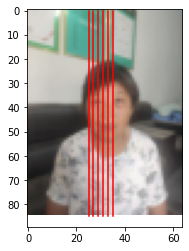

186


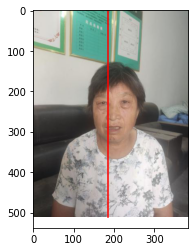

[(25, 0.871875), (27, 0.8778935185185185), (29, 0.849676724137931), (31, 0.8432459677419355), (33, 0.8361742424242424), (35, 0.7964285714285714)]


In [11]:
get_center_vline(dataset[4][0])

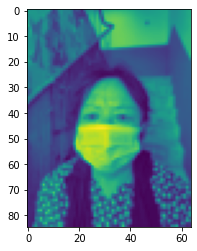

In [102]:
MOD = 64
transform = transforms.Compose([
    transforms.Resize((int(MOD*(4/3)), MOD))
    ])

sample = dataset[5][0]
v, v_rescaled= get_center_vline(sample)

blurred = np.array(transform(sample))
blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
plt.imshow(blurred_gray)

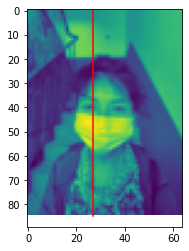

In [154]:
MOD = 64
transform = transforms.Compose([
    transforms.Resize((int(MOD*(4/3)), MOD))
    ])

sample = dataset[48][0]
v, v_rescaled= get_center_vline(sample)

blurred = np.array(transform(sample))
blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

coord_x = (v, v)
coord_y = (0, 85)
plt.imshow(blurred_gray)
plt.plot(coord_x, coord_y, c='red')
plt.show()

(512, 384, 3)

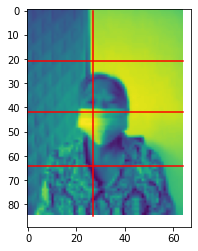

In [199]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

MOD = 64
transform = transforms.Compose([
    transforms.Resize((int(MOD*(4/3)), MOD))
    ])

sample = dataset[1000][0]
v, v_rescaled= get_center_vline(sample)

blurred = np.array(transform(sample))
blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

v0 = moving_average(blurred_gray[:, v], 7) # 단순이동평균
v1 = np.roll(v0, shift=1, axis=0)
length = v0.shape[0]
h1 = np.argmax(np.abs(v0[int(length*0.65):-1] - v1[int(length*0.65):-1])) + int(length*0.6)
h2 = np.argmax(np.abs(v0[1:int(length*0.35)] - v1[1:int(length*0.35)]))

coord_v = (v, v)
coord_y = (0, 85)

coord_x = (0, 64)
coord_h1 = (h1, h1)
coord_h2 = (h2, h2)

h = (h1 + h2) // 2
coord_h = (h, h)

plt.imshow(blurred_gray)
plt.plot(coord_x, coord_h1, c='red')
plt.plot(coord_x, coord_h2, c='red')
plt.plot(coord_x, coord_h, c='red')
plt.plot(coord_v, coord_y, c='red')
np.array(sample).shape